In [2]:

import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def Sub_A(p, x_0):
    # Схема подразделений через преобразование Фурье.
    # Здесь предполагается, что последовательность x_0
    # периодическая и задана на периоде [0; n_1 - 1] x ...
    # p -- маска -- массив numpy размера q < min n_i
    s = len(x_0.shape)
    if (s == 1):
        a = p.copy()
    elif (s == 2):
        a = np.tensordot(p, p, axes = 0)
    else:
        a = np.tensordot(p, np.tensordot(p, p, axes = 0), axes = 0)
    x = x_0.copy() 
    
    Up_x = np.zeros(tuple(2 * np.array(x.shape)))
    DFT_a = np.zeros(Up_x.shape)
    if (s == 1):
        Up_x[::2] = x[:]
        DFT_a[:a.shape[0]] = a[:]
        DFT_a = np.fft.fftn(DFT_a)
    elif (s == 2):
        Up_x[::2, ::2] = x[:, :]
        DFT_a[:a.shape[0], :a.shape[1]] = a[:, :]
        DFT_a = np.fft.fftn(DFT_a)
    else:
        Up_x[::2, ::2, ::2] = x[:, :, :]
        DFT_a[:a.shape[0], :a.shape[1], :a.shape[2]] = a[:, :, :]
        DFT_a = np.fft.fftn(DFT_a)
    x = np.fft.ifftn(DFT_a * np.fft.fftn(Up_x)).real
    return x

In [176]:
def Sub_A_torch(mask: torch.Tensor, x_0: torch.Tensor):
    """
    x_0: torch.Tensor
       shape:
         1D: (L)
         2D: (H, W)
         3D: (D, H, W)

    mask: torch.Tensor
       shape:
         1D: (kd)
    """
    
    s = len(x_0.shape)
    if (s == 1):
        kernel = mask.clone()
        conv_func = F.conv1d
    elif (s == 2):
        kernel = torch.einsum('i,j->ij', mask, mask)
        conv_func = F.conv2d
    else:
        kernel = torch.einsum('i,j,k->ijk', mask, mask, mask)
        conv_func = F.conv3d
    
    #Переворот ядра
    kernel = kernel.flip(tuple(range(s)))
    #Добавляем новую размерность для соответствия протоколу convNd
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    
    x = x_0.clone()
    Up_x = torch.zeros(1, 1, *(2 * np.array(x.shape)))

    
    #upsample + padd
    if (s==1):
        Up_x[..., ::2] = x[:]
    elif (s==2):
        Up_x[..., ::2, ::2] = x[:, :, ]
    else:
        Up_x[..., ::2, ::2, ::2] = x[:, :, :]
        

    # padding по каждой оси
    pads = []
    for k in reversed(kernel.shape[2:]):
        p = k // 2
        pads.extend([p, p])

    # pads в нужном порядке (W, H, D)
    Up_x_padded = F.pad(Up_x, pads)
    
    conv_result = conv_func(Up_x_padded, kernel)
    
    return conv_result.squeeze(0).squeeze(0)[:-1:1]
        

ПОСЛЕ 0 ПОДРАЗДЕЛЕНИЙ: tensor([0.0000, 1.0000, 0.5000, 2.0000, 1.5000, 0.0000, 2.5000, 2.0000, 3.0000,
        0.0000])
ПОСЛЕ 1 ПОДРАЗДЕЛЕНИЙ: tensor([0.0000, 0.3333, 0.6667, 0.8333, 0.6667, 1.0000, 1.5000, 1.8333, 1.6667,
        1.0000, 0.5000, 0.8333, 1.6667, 2.3333, 2.1667, 2.3333, 2.6667, 2.0000,
        1.0000])
ПОСЛЕ 2 ПОДРАЗДЕЛЕНИЙ: tensor([0.0000, 0.1111, 0.2222, 0.4444, 0.5556, 0.7222, 0.7778, 0.7778, 0.7222,
        0.7778, 0.8889, 1.1667, 1.3333, 1.6111, 1.7222, 1.7778, 1.7222, 1.4444,
        1.2222, 0.8333, 0.6667, 0.6111, 0.7222, 1.1111, 1.3889, 1.8889, 2.1111,
        2.2778, 2.2222, 2.2222, 2.2778, 2.4444, 2.5556, 2.4444, 2.2222, 1.6667,
        1.3333])
ПОСЛЕ 3 ПОДРАЗДЕЛЕНИЙ: tensor([0.0000, 0.0370, 0.0741, 0.1481, 0.1852, 0.2963, 0.3704, 0.4815, 0.5185,
        0.6111, 0.6667, 0.7407, 0.7593, 0.7778, 0.7778, 0.7593, 0.7407, 0.7407,
        0.7593, 0.8148, 0.8519, 0.9815, 1.0741, 1.2222, 1.2778, 1.4259, 1.5185,
        1.6481, 1.6852, 1.7407, 1.7593, 1.7593, 1.7407, 1

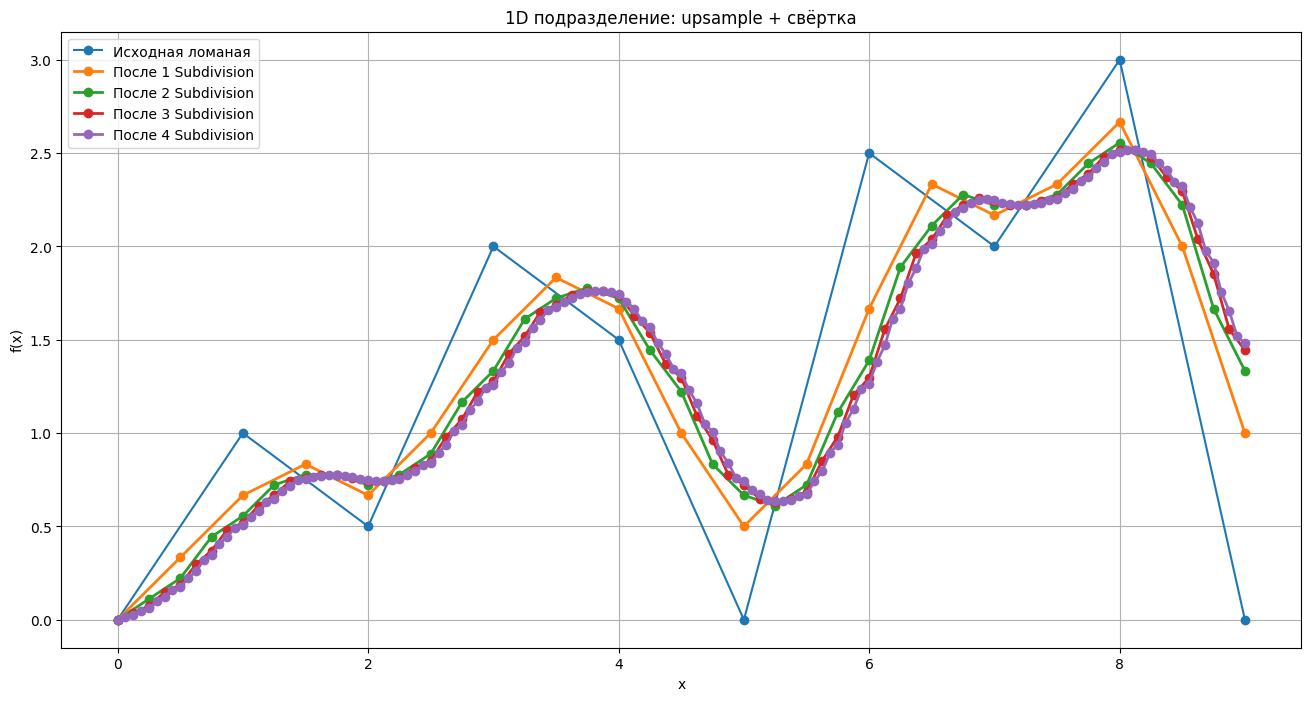

In [4]:
# mask = torch.tensor([0, 0, 2, 2, 0], dtype=torch.float32) / 2
# mask = torch.tensor([0, 1, 2, 2, 1], dtype=torch.float32) / 3
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4
# mask = torch.tensor([0, 1, 5, 5, 1], dtype=torch.float32) / 6
# mask = torch.tensor([0, 1, 9, 9, 1], dtype=torch.float32) / 10




x0 = torch.tensor([0.0, 1.0, 0.5, 2.0, 1.5, 0.0, 2.5, 2.0, 3.0, 0])
t0 = np.linspace(0, len(x0) - 1, len(x0))
print(f"ПОСЛЕ {0} ПОДРАЗДЕЛЕНИЙ: {x0}")

plt.figure(figsize=(16, 8))
plt.plot(t0, x0.numpy(), 'o-', label='Исходная ломаная')

# маска подразделения
# применение подразделения

x_temp = x0.clone()
for i in range(1,5):

    
    x_temp = Sub_A_torch(mask, x_temp)
    print(f"ПОСЛЕ {i} ПОДРАЗДЕЛЕНИЙ: {x_temp}")
    t1 = np.linspace(0, len(x0) - 1, len(x_temp))
    
    plt.plot(t1, x_temp.detach().numpy(), 'o-', linewidth=2, label=f'После {i} Subdivision')
    
# plt.plot(t2, x2.detach().numpy(), 'o--', linewidth=2, label='После x2 Subdivision')
# plt.plot(t3, x3.detach().numpy(), 'o--', linewidth=2, label='После x3 Subdivision')



plt.legend()
plt.grid(True)
plt.title("1D подразделение: upsample + свёртка")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


In [221]:
def plot_subdivision_points(data: torch.Tensor, 
                            threshold=0.05, 
                            title="", 
                            figsize = (6,6), 
                            do_ceil = False,
                            visual_type = "scatter"):
    """
    data:
        2D: (H, W)
        3D: (D, H, W)
    """
    v = data.detach().cpu()
    
    if do_ceil:
        v = (v > threshold).float()
    
    idx = torch.nonzero(v > threshold)

    if v.ndim == 2:
        y = idx[:, 0].numpy()
        x = idx[:, 1].numpy()
        vals = v[idx[:, 0], idx[:, 1]]

        plt.figure(figsize=figsize)
        
        if visual_type == "scatter":
            plt.scatter(
                x, y,
                c=vals.numpy(),
                cmap="viridis",
                s=10
            )
        
        else:
            plt.imshow(v, 
            cmap='viridis', 
            aspect='auto',
            origin='lower',)
        
        plt.colorbar(label="f value")
        plt.gca().set_aspect("equal")
        plt.title(title)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()

    elif v.ndim == 3:
        z = idx[:, 0].numpy()
        y = idx[:, 1].numpy()
        x = idx[:, 2].numpy()
        vals = v[idx[:, 0], idx[:, 1], idx[:, 2]]

        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection="3d")

        p = ax.scatter(
            x, y, z,
            c=vals.numpy(),
            cmap="viridis",
            s=5,
            alpha=0.7
        )

        fig.colorbar(p, ax=ax, shrink=0.6, label="f value")

        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Поддерживаются только 2D и 3D данные")


In [6]:
def make_sphere(grid_size=32, radius=10):
    x = torch.linspace(-grid_size//2, grid_size//2, grid_size)
    X, Y, Z = torch.meshgrid(x, x, x, indexing='ij')
    sphere = (X**2 + Y**2 + Z**2 <= radius**2).float()
    return sphere



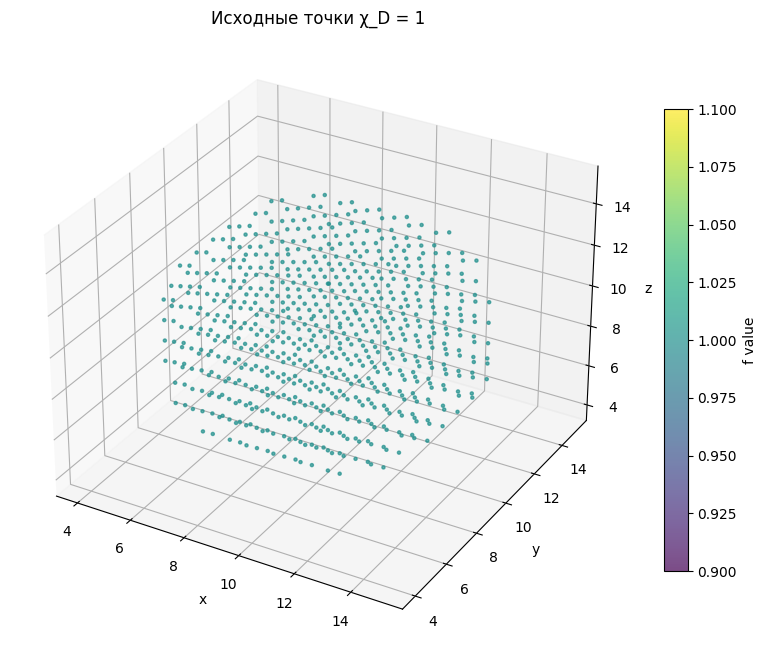

In [11]:
x0 = make_sphere(grid_size=20, radius=6)

plot_subdivision_points(
    x0,
    threshold=0.01,
    title="Исходные точки χ_D = 1"
)

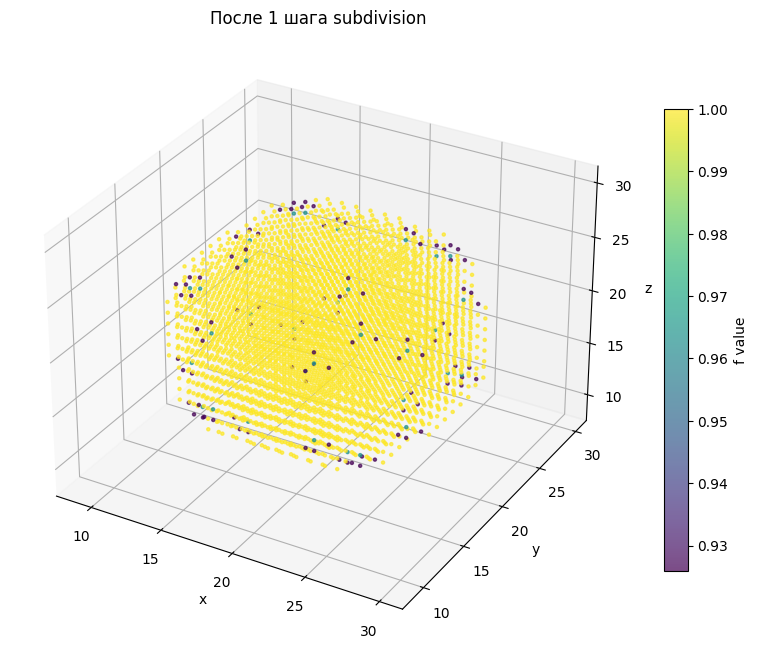

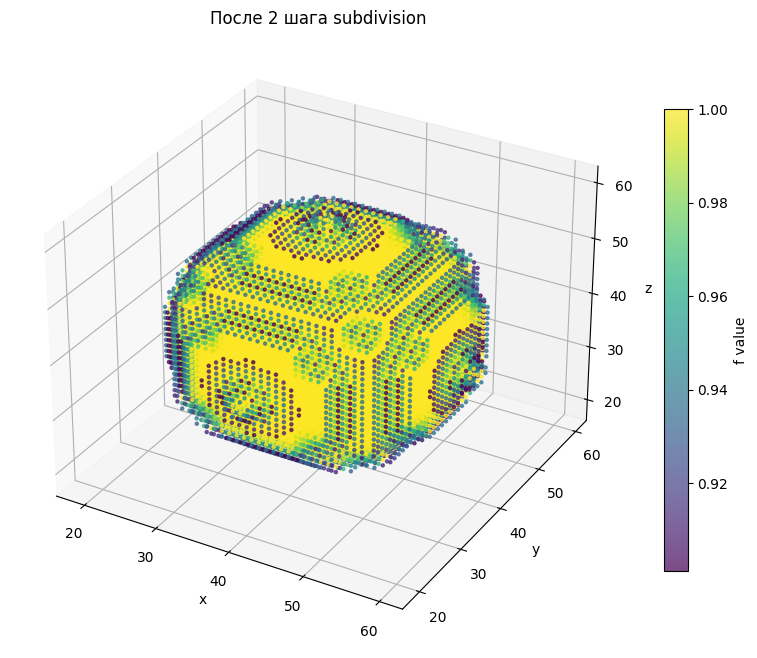

In [12]:
x = x0.clone()
for i in range(2):
    x = Sub_A_torch(mask, x)
    plot_subdivision_points(
        x,
        threshold=0.9,
        title=f"После {i+1} шага subdivision"
    )

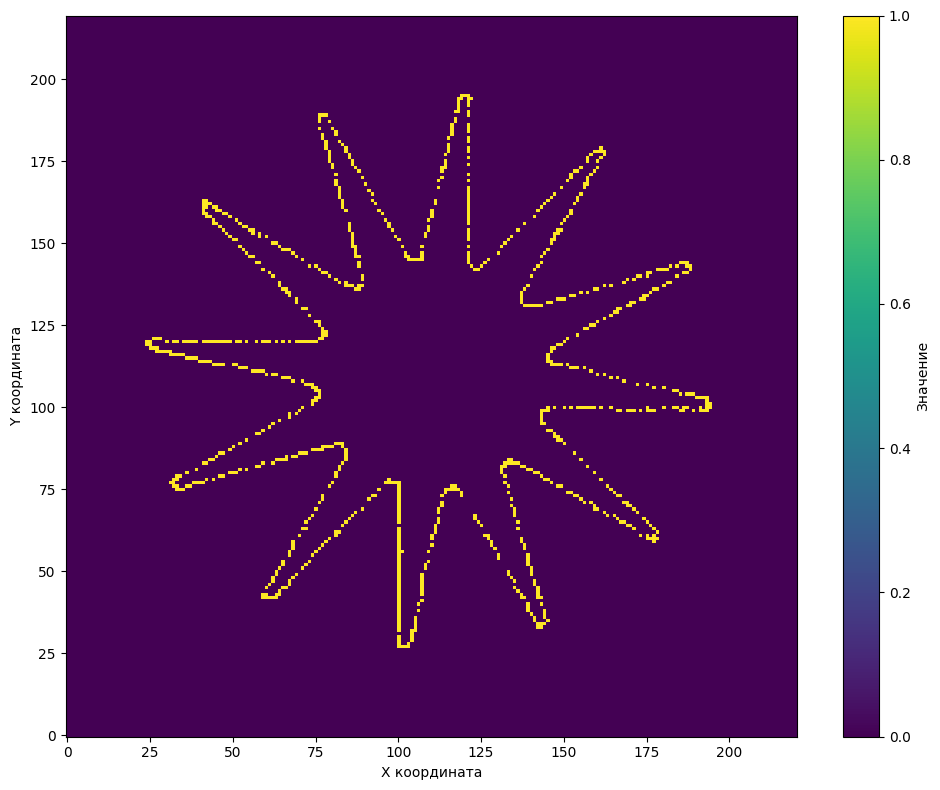

In [214]:
coef = 4

raw_data = np.loadtxt('./models/Turbine.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*coef*np.power(10,0)).astype(int).reshape(-1, 3)

shifted = (int_cast_data - int_cast_data.min(axis=0) + 1*np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + 1*np.array([20,20, 20])).astype(int)

tensor_3d = torch.zeros(tuple(sizes), dtype=int)
tensor_3d[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

turbine_slice = tensor_3d[:,:, 55]

plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

# plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



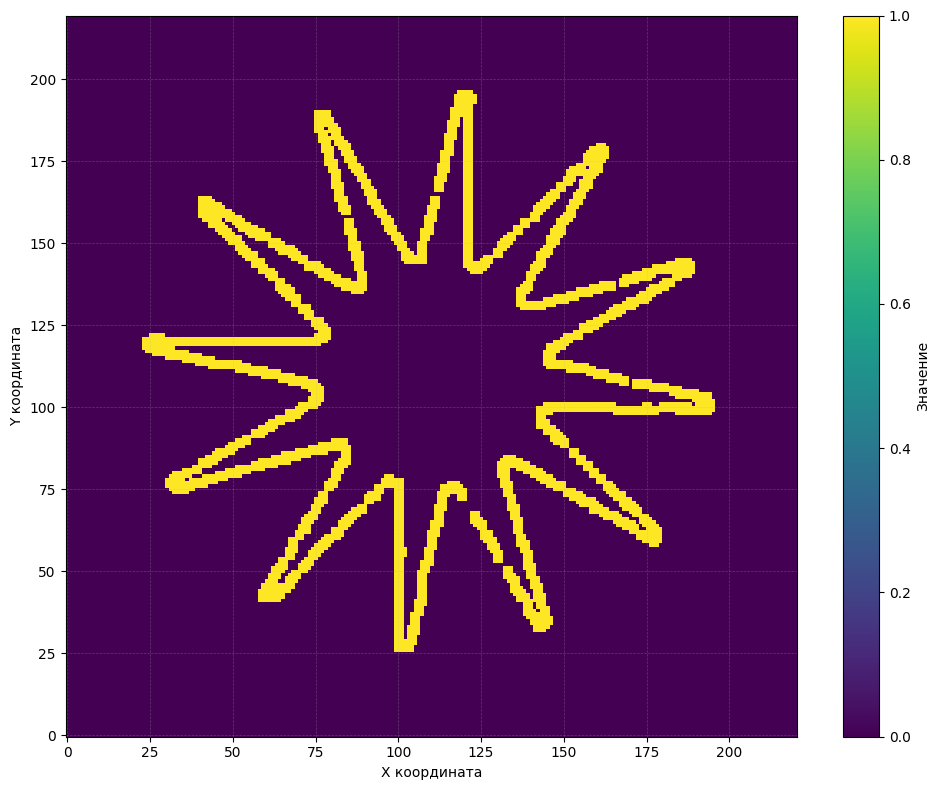

In [215]:
kernel_shape = 3
turbine_slice_conv_result = make_conv_3d_torch(source=turbine_slice, kernel=torch.ones(size=(kernel_shape,kernel_shape,kernel_shape)))


plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice_conv_result, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_result.png')
plt.show()

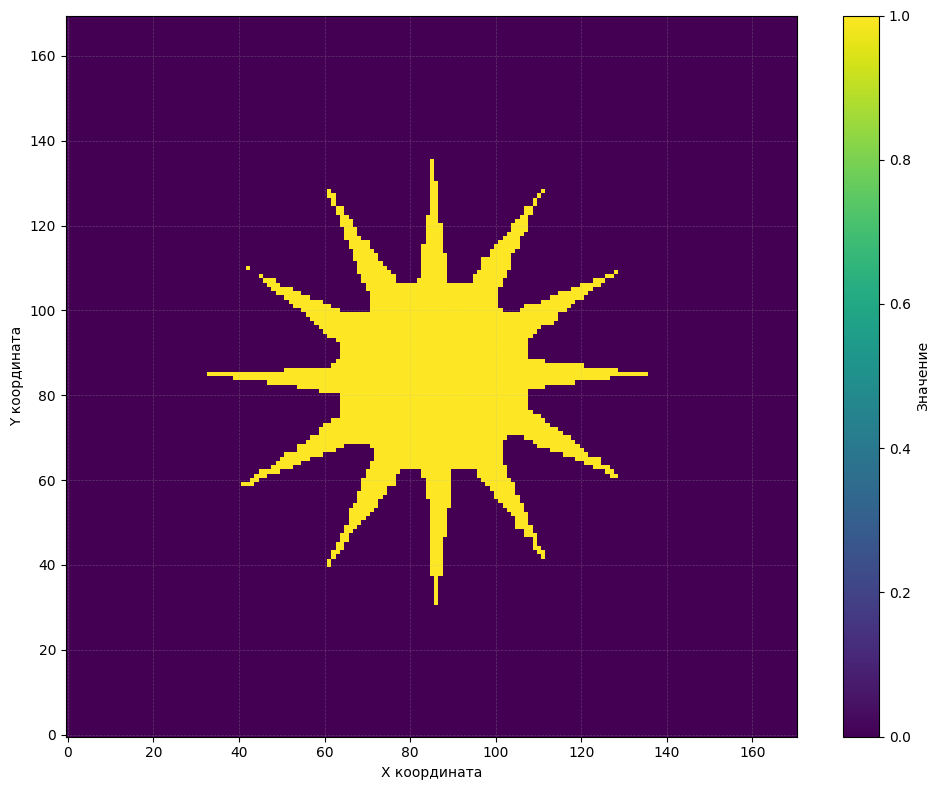

In [188]:
turbine_slice_conv_filled = morph_fill(turbine_slice_conv_result)


plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice_conv_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

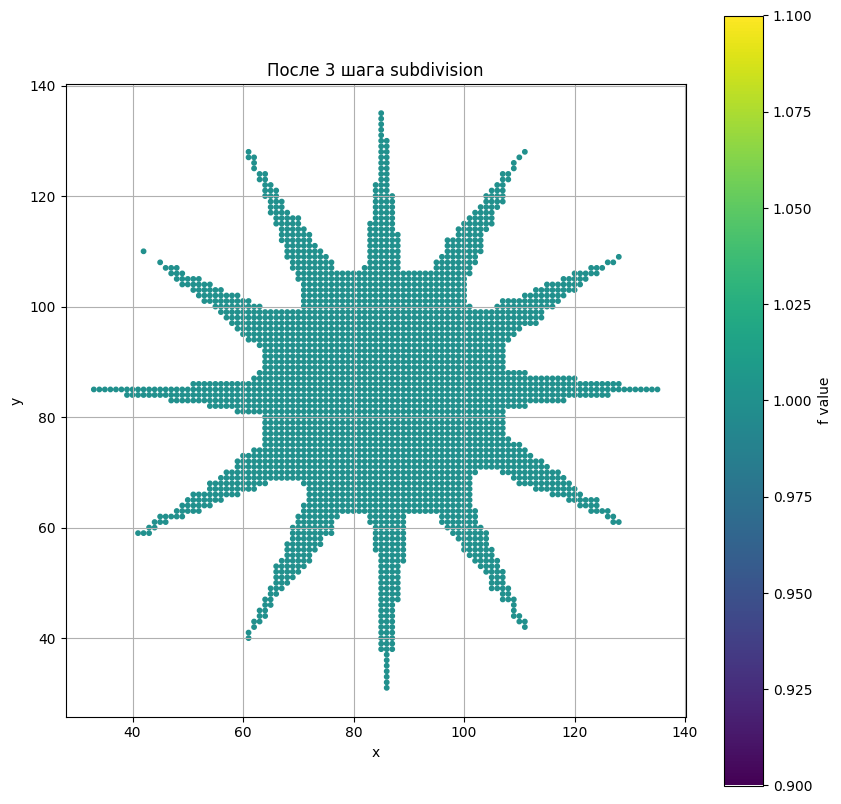

In [226]:
plot_subdivision_points(
        turbine_slice_conv_filled,
        threshold=0.01,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10)
    )

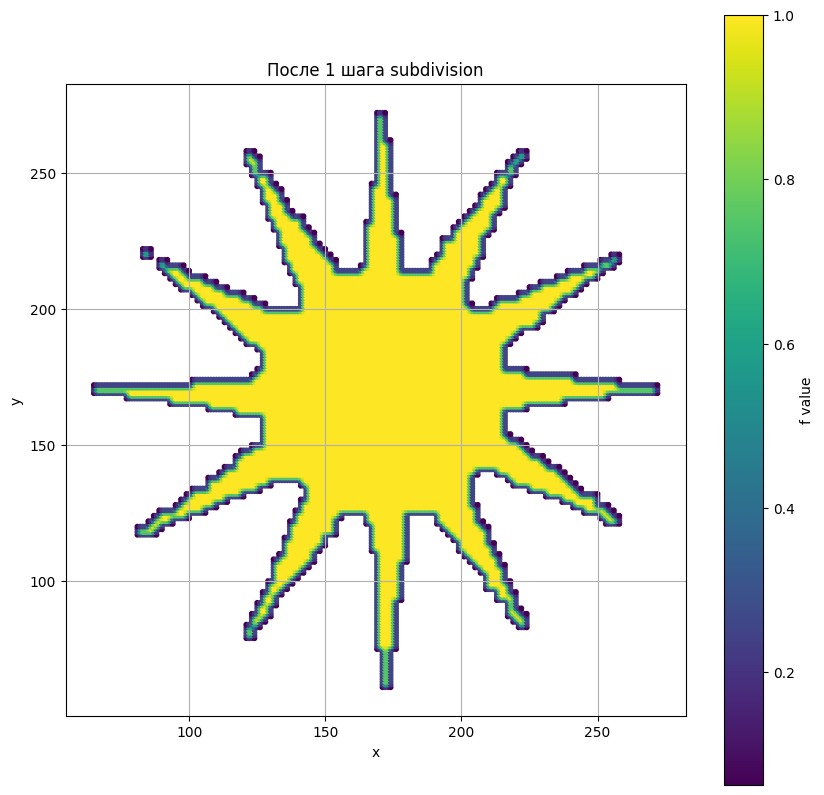

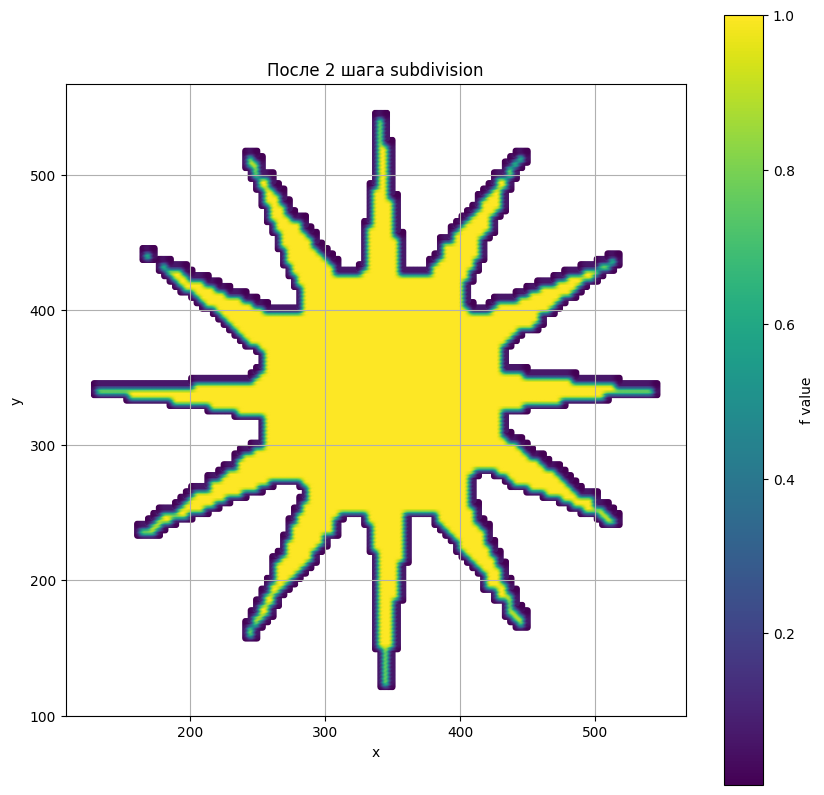

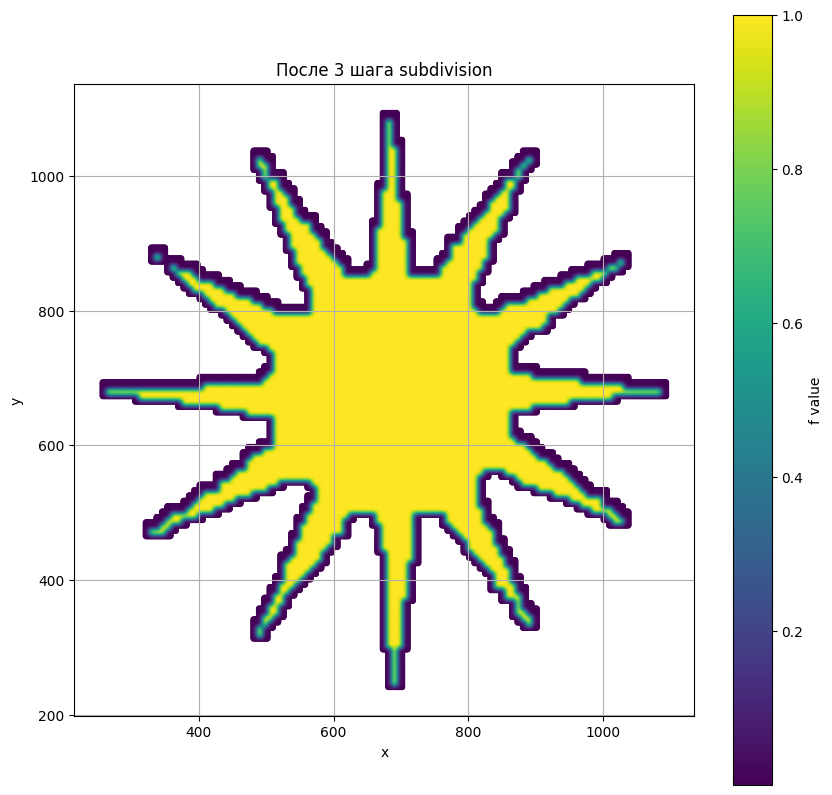

In [201]:
step = 1
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

turbine_slice_conv_filled_sub = turbine_slice_conv_filled.clone()[::step,::step]
for i in range(3):
    turbine_slice_conv_filled_sub = Sub_A_torch(mask, turbine_slice_conv_filled_sub)
    plot_subdivision_points(
        turbine_slice_conv_filled_sub,
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10)
    )

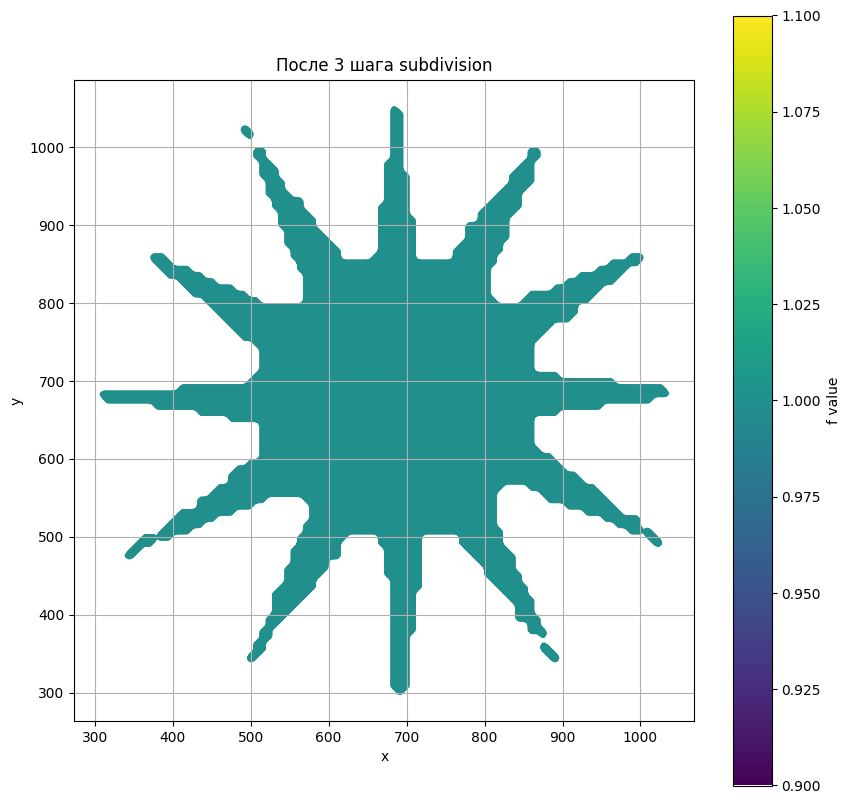

In [225]:
plot_subdivision_points(
        turbine_slice_conv_filled_sub,
        threshold=0.8,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil=True,
        visual_type='scatter'
    )

In [137]:
# mask = torch.tensor([1 / 8, 4 / 8, 6 / 8, 4 / 8, 1 / 8])
mask = torch.ones(size=(3,))


turbine_slice_conv = Sub_A_torch(mask=mask, x_0 = tensor_slice)
threshold = 0
turbine_slice_conv = (turbine_slice_conv.squeeze(0).squeeze(0) > threshold).float()

In [124]:
turbine_slice_conv.nonzero().shape
# turbine_slice_conv.squeeze(0).squeeze(0).shape

torch.Size([11192, 2])

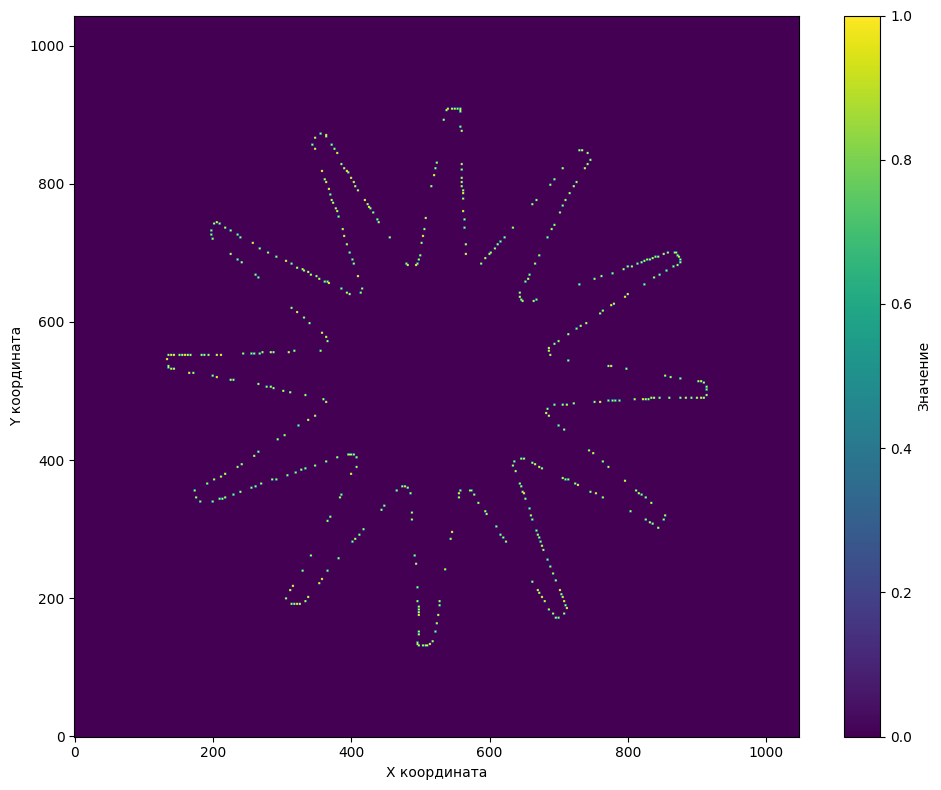

In [138]:
plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice_conv, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

# plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()